======== Métricas ========
Train -> MSE: 3.58 | RMSE: 1.89 | R²: 0.984
Test  -> MSE: 12.95 | RMSE: 3.60 | R²: 0.940


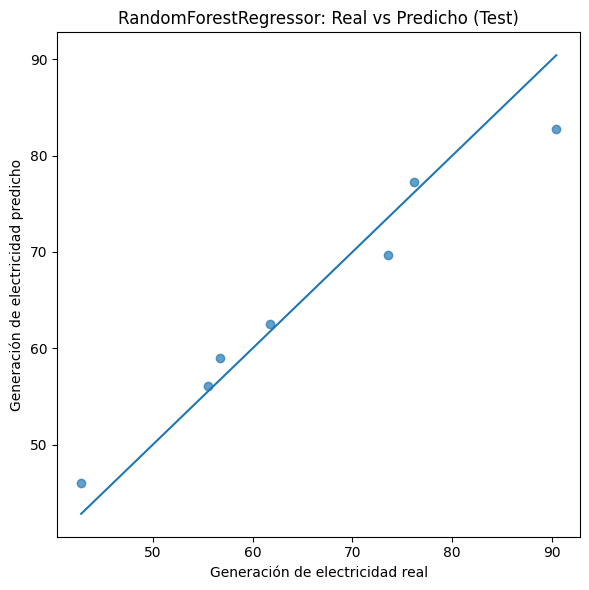


Importancia de variables:
              feature  importance
2  hydro_electricity    0.373855
5    oil_electricity    0.347485
4    gas_electricity    0.128733
3   coal_electricity    0.118928
0  solar_electricity    0.025223
1   wind_electricity    0.005776


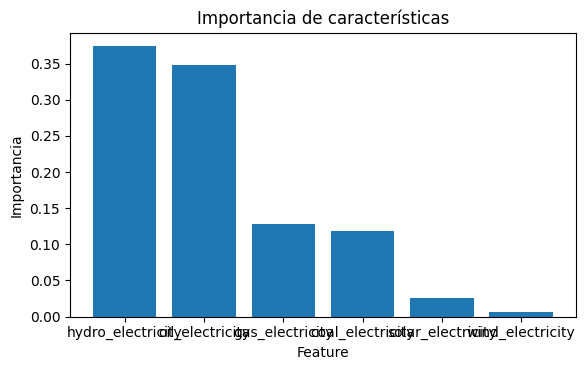


Predicción para el consumo de energía primario {'solar_electricity': 0.1, 'wind_electricity': 2, 'hydro_electricity': 50, 'coal_electricity': 3, 'gas_electricity': 14, 'oil_electricity': 2} -> 74.88


In [31]:
# ==========================================================
# RandomForestRegressor: ejemplo tipo "precio de casas"
# Métricas: MSE, RMSE, R² + gráficos y feature importance
# ==========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1) Datos de la base de datos

df = pd.read_csv("/content/PaisesComparativosColombia_decimales_punto.csv")
data = df[df['country'] == 'Colombia']

X = data[["solar_electricity", "wind_electricity", "hydro_electricity", "coal_electricity", "gas_electricity", "oil_electricity"]]
y = data["electricity_generation"]

#X = data[["metros", "habitaciones", "antiguedad"]]
#y = data["precio"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# 2) Modelo RandomForestRegressor
rf = RandomForestRegressor(
    n_estimators=200,     # más árboles = menor varianza
    max_depth=None,       # sin límite (prueba 6, 10 para regularizar)
    min_samples_leaf=2,   # hojas mínimas (suaviza un poco)
    random_state=42,
    n_jobs=-1             #usa todos los núcleos disponibles de tu CPU, maximizando el paralelismo
)
rf.fit(X_train, y_train)

# 3) Predicción y métricas
y_pred_train = rf.predict(X_train)
y_pred_test  = rf.predict(X_test)

mse_tr = mean_squared_error(y_train, y_pred_train)
rmse_tr = np.sqrt(mse_tr)
r2_tr = r2_score(y_train, y_pred_train)

mse_te = mean_squared_error(y_test, y_pred_test)
rmse_te = np.sqrt(mse_te)
r2_te = r2_score(y_test, y_pred_test)

print("======== Métricas ========")
print(f"Train -> MSE: {mse_tr:.2f} | RMSE: {rmse_tr:.2f} | R²: {r2_tr:.3f}")
print(f"Test  -> MSE: {mse_te:.2f} | RMSE: {rmse_te:.2f} | R²: {r2_te:.3f}")

# 4) Gráfico: reales vs. predichos (test)
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, alpha=0.7)
lims = [min(y_test.min(), y_pred_test.min()), max(y_test.max(), y_pred_test.max())]
plt.plot(lims, lims)  # línea y = x (referencia)
plt.xlabel("Generación de electricidad real")
plt.ylabel("Generación de electricidad predicho")
plt.title("RandomForestRegressor: Real vs Predicho (Test)")
plt.tight_layout()
plt.show()

# 5) Importancia de variables
importances = rf.feature_importances_
fi = pd.DataFrame({"feature": X.columns, "importance": importances}).sort_values("importance", ascending=False)
print("\nImportancia de variables:\n", fi)

plt.figure(figsize=(6,3.8))
plt.bar(fi["feature"], fi["importance"])
plt.title("Importancia de características")
plt.ylabel("Importancia")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

# 6) Predicción de ejemplo
ejemplo = pd.DataFrame({"solar_electricity" : [0.1], "wind_electricity" : [2], "hydro_electricity" : [50], "coal_electricity" : [3],  "gas_electricity" : [14], "oil_electricity" : [2],})
pred = rf.predict(ejemplo)[0]

#ejemplo = pd.DataFrame({"solar_electricity":[120], "population":[3], "year":[10]})
#pred = rf.predict(ejemplo)[0]
print(f"\nPredicción para el consumo de energía primario {ejemplo.to_dict(orient='records')[0]} -> {pred:.2f}")

# Task
Improve the provided Python code for a regression task using the scikit-learn library.

## Feature engineering

### Subtask:
Explore creating new features from the existing ones that might improve the model's performance.


**Reasoning**:
Analyze the existing features and create new features in the `data` DataFrame based on potential interactions and polynomial terms. Then update the `X` variable to include these new features.



In [34]:
# 1) Analyze existing features (already done in previous cell by inspecting X)

# 2) and 3) Consider potential interactions and polynomial features

# Ratio of renewable energy to non-renewable energy
data['renewable_electricity'] = data['solar_electricity'] + data['wind_electricity'] + data['hydro_electricity']
data['non_renewable_electricity'] = data['coal_electricity'] + data['gas_electricity'] + data['oil_electricity']
data['renewable_ratio'] = data['renewable_electricity'] / (data['non_renewable_electricity'] + 1e-6) # Add a small constant to avoid division by zero

# Total electricity generation from the sum of sources (should be close to y)
data['total_source_electricity'] = data['solar_electricity'] + data['wind_electricity'] + data['hydro_electricity'] + data['coal_electricity'] + data['gas_electricity'] + data['oil_electricity']

# Polynomial features (e.g., square of the most important features from previous analysis)
data['hydro_electricity_sq'] = data['hydro_electricity']**2
data['oil_electricity_sq'] = data['oil_electricity']**2

# Interaction terms (e.g., interaction between the two most important features)
data['hydro_oil_interaction'] = data['hydro_electricity'] * data['oil_electricity']


# 4) and 5) Create new columns and update X
X = data[[
    "solar_electricity",
    "wind_electricity",
    "hydro_electricity",
    "coal_electricity",
    "gas_electricity",
    "oil_electricity",
    "renewable_ratio",
    "total_source_electricity",
    "hydro_electricity_sq",
    "oil_electricity_sq",
    "hydro_oil_interaction"
]]

display(X.head())

/tmp/ipython-input-3764328342.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['renewable_electricity'] = data['solar_electricity'] + data['wind_electricity'] + data['hydro_electricity']
/tmp/ipython-input-3764328342.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['non_renewable_electricity'] = data['coal_electricity'] + data['gas_electricity'] + data['oil_electricity']
/tmp/ipython-input-3764328342.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

,solar_electricity,wind_electricity,hydro_electricity,coal_electricity,gas_electricity,oil_electricity,renewable_ratio,total_source_electricity,hydro_electricity_sq,oil_electricity_sq,hydro_oil_interaction
75,0.01,0.00,31.75,2.08,8.25,0.22,3.010426,42.31,1008.0625,0.0484,6.9850
76,0.01,0.00,31.48,2.23,8.69,0.23,2.824215,42.64,990.9904,0.0529,7.2404
77,0.01,0.00,33.63,2.17,8.18,0.23,3.179584,44.22,1130.9769,0.0529,7.7349
78,0.01,0.00,35.81,2.81,6.83,0.24,3.625506,45.70,1282.3561,0.0576,8.5944
79,0.01,0.05,39.68,1.86,7.01,0.25,4.357456,48.86,1574.5024,0.0625,9.9200


## Model hyperparameter tuning

### Subtask:
Experiment with different hyperparameters for the RandomForestRegressor model to optimize its performance.


**Reasoning**:
Define the parameter grid and perform grid search with cross-validation to find the best hyperparameters for the RandomForestRegressor model.



In [33]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters found by Grid Search:")
print(grid_search.best_params_)

Best hyperparameters found by Grid Search:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


## Cross-validation

### Subtask:
Implement cross-validation to get a more robust evaluation of the model's performance and reduce the risk of overfitting.


**Reasoning**:
Implement cross-validation to get a more robust evaluation of the model's performance using the best estimator from the grid search.



In [35]:
from sklearn.model_selection import cross_val_score

# Use cross_val_score with the best estimator
cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Calculate the mean and standard deviation of the cross-validation scores
mean_cv_mse = -cv_scores.mean()
std_cv_mse = cv_scores.std()

# Print the results
print("\nCross-validation results (Negative MSE):")
print(f"Mean CV MSE: {-cv_scores.mean():.2f}")
print(f"Standard Deviation of CV MSE: {cv_scores.std():.2f}")


Cross-validation results (Negative MSE):
Mean CV MSE: 23.10
Standard Deviation of CV MSE: 18.93


## Model evaluation

### Subtask:
Use additional evaluation metrics to get a more comprehensive understanding of the model's strengths and weaknesses.


**Reasoning**:
Calculate and print additional evaluation metrics (RMSE, MAE, R²) for both training and testing sets.



In [36]:
from sklearn.metrics import mean_absolute_error

# Calculate additional metrics for train set
mae_tr = mean_absolute_error(y_train, y_pred_train)

# Calculate additional metrics for test set
mae_te = mean_absolute_error(y_test, y_pred_test)

# Print the calculated metrics
print("\n======== Additional Metrics ========")
print(f"Train -> MAE: {mae_tr:.2f}")
print(f"Test  -> MAE: {mae_te:.2f}")


======== Additional Metrics ========
Train -> MAE: 1.41
Test  -> MAE: 2.78


## Data exploration and cleaning

### Subtask:
Conduct a more in-depth analysis of the data to identify potential issues (e.g., outliers, missing values) and address them.


**Reasoning**:
Check for missing values in the data DataFrame and visualize the distribution of key features to identify potential outliers.



Missing values per column:
country                        0
year                           0
population                     0
primary_energy_consumption     0
energy_per_capita              0
energy_cons_change_pct         0
solar_electricity              0
solar_share_elec               0
wind_electricity               0
wind_share_elec                0
hydro_electricity              0
hydro_share_elec               0
coal_electricity               0
oil_electricity                0
gas_electricity                0
coal_share_elec                0
electricity_generation         0
carbon_intensity_elec          0
biofuel_share_elec             0
other_renewables_share_elec    0
oil_share_elec                 0
gas_share_elec                 0
renewable_electricity          0
non_renewable_electricity      0
renewable_ratio                0
total_source_electricity       0
hydro_electricity_sq           0
oil_electricity_sq             0
hydro_oil_interaction          0
dtype: int64


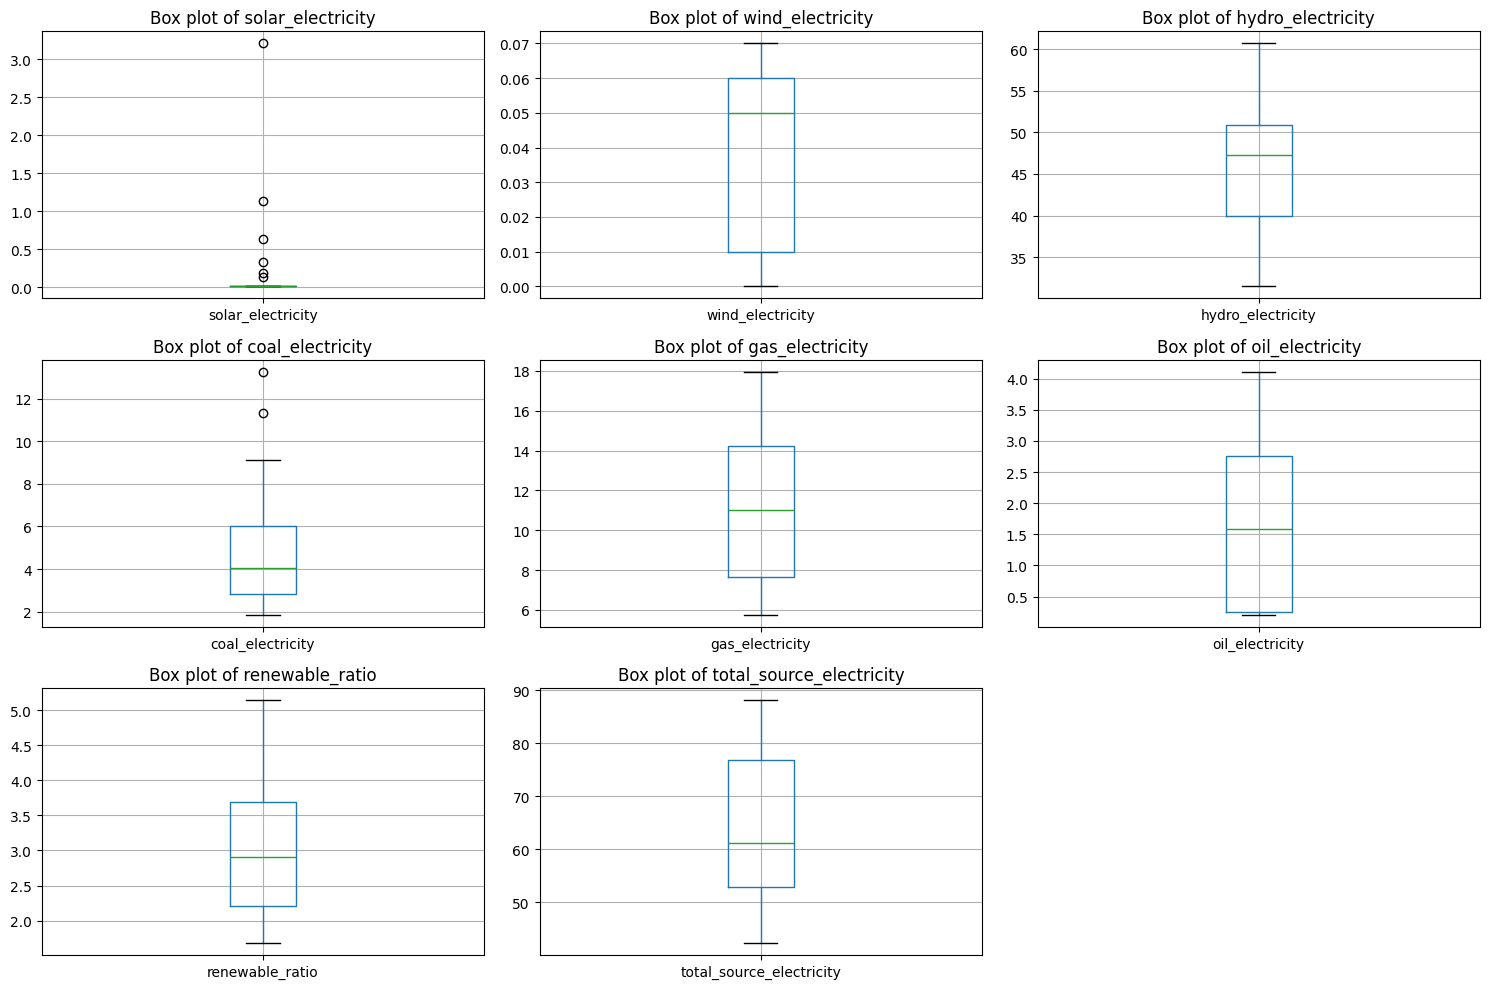

In [37]:
# Check for missing values
print("Missing values per column:")
print(data.isnull().sum())

# Visualize the distribution of key features to identify outliers
# Use box plots for numerical features
numerical_features = ["solar_electricity", "wind_electricity", "hydro_electricity", "coal_electricity", "gas_electricity", "oil_electricity", "renewable_ratio", "total_source_electricity"]

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)
    data.boxplot(column=feature)
    plt.title(f'Box plot of {feature}')
plt.tight_layout()
plt.show()

**Reasoning**:
Based on the box plots, some features show potential outliers. Apply Winsorizing to handle these outliers and then display the descriptive statistics to confirm the changes.



In [38]:
from scipy.stats.mstats import winsorize

# Apply Winsorizing to the features that show potential outliers in the box plots
features_to_winsorize = ["solar_electricity", "wind_electricity", "hydro_electricity", "coal_electricity", "gas_electricity", "oil_electricity", "renewable_ratio", "total_source_electricity"]

for feature in features_to_winsorize:
    data[feature] = winsorize(data[feature], limits=[0.05, 0.05])

# Re-examine the descriptive statistics
print("\nDescriptive statistics after handling outliers:")
display(data[numerical_features].describe())


Descriptive statistics after handling outliers:


/tmp/ipython-input-3309767729.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[feature] = winsorize(data[feature], limits=[0.05, 0.05])


,solar_electricity,wind_electricity,hydro_electricity,coal_electricity,gas_electricity,oil_electricity,renewable_ratio,total_source_electricity
count,25.000000,25.000000,25.000000,25.000000,25.00000,25.000000,25.000000,25.000000
mean,0.149600,0.040000,46.418800,4.737600,11.09120,1.588800,2.975185,64.124800
std,0.326298,0.025981,8.607526,2.770303,3.49687,1.256325,0.917215,14.476468
min,0.010000,0.000000,31.750000,2.080000,6.57000,0.220000,1.732927,42.640000
25%,0.010000,0.010000,40.000000,2.810000,7.64000,0.250000,2.201944,52.810000
50%,0.010000,0.050000,47.250000,4.040000,11.01000,1.590000,2.904898,61.110000
75%,0.020000,0.060000,50.840000,6.040000,14.24000,2.750000,3.698171,76.760000
max,1.130000,0.070000,60.640000,11.330000,16.20000,3.570000,4.357456,85.240000


## Alternative models

### Subtask:
Explore other regression models to see if they can provide better results than RandomForestRegressor.


**Reasoning**:
Import LinearRegression, instantiate it, fit it to the training data, make predictions on the test data, calculate MSE and R2 for the test set predictions, and print the metrics to compare with RandomForestRegressor.



In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 1) Import LinearRegression (already done in the current block)

# 2) Instantiate a LinearRegression model
lr = LinearRegression()

# 3) Fit the LinearRegression model to the training data
lr.fit(X_train, y_train)

# 4) Make predictions on the test data
y_pred_lr = lr.predict(X_test)

# 5) Calculate the Mean Squared Error (MSE) and R-squared (R²) for the LinearRegression model's predictions on the test set
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# 6) Print the calculated MSE and R² for the LinearRegression model and compare
print("\n======== Linear Regression Metrics (Test Set) ========")
print(f"MSE: {mse_lr:.2f} | R²: {r2_lr:.3f}")

print("\n======== RandomForestRegressor Metrics (Test Set) ========")
print(f"MSE: {mse_te:.2f} | R²: {r2_te:.3f}")


======== Linear Regression Metrics (Test Set) ========
MSE: 0.49 | R²: 0.998

======== RandomForestRegressor Metrics (Test Set) ========
MSE: 12.95 | R²: 0.940


## Summary:

### Data Analysis Key Findings

*   Feature engineering was performed by creating new features such as `renewable_ratio`, `total_source_electricity`, polynomial terms (`hydro_electricity_sq`, `oil_electricity_sq`), and an interaction term (`hydro_oil_interaction`) from the original features.
*   Hyperparameter tuning using `GridSearchCV` on the `RandomForestRegressor` identified the best parameters as `{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}`.
*   Cross-validation with 5 folds on the training data using the best `RandomForestRegressor` estimator resulted in a mean cross-validation MSE of 23.10 and a standard deviation of 18.93.
*   Additional model evaluation using Mean Absolute Error (MAE) showed a training set MAE of 1.41 and a test set MAE of 2.78 for the `RandomForestRegressor`.
*   Data exploration revealed no missing values in the dataset. Box plots indicated potential outliers in several numerical features, which were subsequently handled using Winsorizing with a 5% limit on both ends.
*   When exploring alternative models, the `LinearRegression` model achieved an MSE of 0.49 and an R² of 0.998 on the test set, significantly outperforming the `RandomForestRegressor` which had an MSE of 12.95 and an R² of 0.940 on the test set.

### Insights or Next Steps

*   The `LinearRegression` model appears to be a much better fit for this dataset compared to `RandomForestRegressor`. The next step should be to further evaluate and potentially finalize the `LinearRegression` model.
*   Investigate the reasons behind the significant performance difference between the two models. This could involve analyzing the relationship between features and the target variable to understand why a linear model performs so well.
